In [112]:
import os
import configparser
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Example with scene1

In [113]:
data_folder = '/Users/jeffeehsiung/Desktop/master thesis/Seoul_Robotics_lane_detection/pointclouds'
lidar_files = sorted(os.listdir(data_folder))
lidar_fpath = [os.path.join(data_folder, f) for f in lidar_files]
lidar_bin = lidar_fpath[0]
lidar_data = np.fromfile(lidar_bin, dtype=np.float32).reshape(-1, 5)
print(lidar_bin)

/Users/jeffeehsiung/Desktop/master thesis/Seoul_Robotics_lane_detection/pointclouds/1553565729015329642.bin


In [114]:
config = configparser.ConfigParser()
config.read('lidar_config.ini')
scene_number = 4
rot_flag, width_flag, z_flag, width_threshold, z_threshold, rot_angle, inten_up_bound, inten_low_bound, eps, min_samples = get_params_from_config(config, scene_number)

In [115]:
#Data filtering 
print("Original datapoint = %d points" %len(lidar_data))
lidar_data = rotation(lidar_data, rot_flag, rot_angle)
lidar_data = z_filter(lidar_data, z_flag, z_threshold)
lidar_data = spatial_filter(lidar_data)
lidar_data = intensity_filter(lidar_data, inten_up_bound, inten_low_bound)
print("After filtering = %d points remaining" %(len(lidar_data)))

Original datapoint = 38349 points
Number of xy-filtered data points = 23542
Remaining data = 14807
Number of filtered data points = 14217
Remaining data = 590
After filtering = 590 points remaining


In [116]:
lidar_xyz = lidar_data[:, :3]
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(lidar_xyz)
print("Number of cluster = %d" %(max(clustering)+1))

outlier_index = []
cluster_info = []

for lidar_data_index, cluster_numbering in enumerate(clustering):
    if cluster_numbering == -1:
        outlier_index.append(lidar_data_index)
    else:
        cluster_info.append([cluster_numbering])        
print("Number of outlier = %d" %len(outlier_index))
filt_clust_data = np.delete(lidar_data, outlier_index, axis=0)
print("Remaining data = %d" %len(filt_clust_data))

#crosswalk-elimination
if width_flag == True:
    max_width_list = []
    lidar_data_withLabel = np.append(filt_clust_data, cluster_info, axis =1) 
    lidar_data_withLabel = lidar_data_withLabel[np.argsort(lidar_data_withLabel[:, 5])]
    for cluster_index in range(max(clustering)+1):
        lidar_inCluster = lidar_data_withLabel[lidar_data_withLabel[:, -1] == cluster_index]
        max_width = 0
        max_index = (0, 0)
        for index_one_point in range(len(lidar_inCluster) -1): 
            for index_theOther_point in range(1, len(lidar_inCluster)-1): 
                width = np.linalg.norm((lidar_inCluster[index_theOther_point]-lidar_inCluster[index_one_point])[:3])
                if width > max_width:
                    max_width = width
                    max_idx = (index_one_point, index_theOther_point)
        max_width_list.append(max_width)

    forbidden_cluster = []
    
    for index, width in enumerate(max_width_list):
        if width >= width_threshold:
            forbidden_cluster.append(index)
    
    for cluster_index in forbidden_cluster:
        lidar_data_withLabel = lidar_data_withLabel[lidar_data_withLabel[:, -1] != cluster_index]
    lidar_LabelRemoved = lidar_data_withLabel[:, :-1].astype(np.float32)
    filt_clust_data = lidar_LabelRemoved
    print("Remaining data = %d" %len(filt_clust_data))
    
fh = open("scene4.bin", "bw")
filt_clust_data.tofile(fh)

Number of cluster = 45
Number of outlier = 190
Remaining data = 400
Remaining data = 0


ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

In [117]:
def rotation(lidar_data, rot_flag, rot_angle):
    '''
    %% rotate the coordinate system of the given lidar point-cloud
    1. Input:
        - lidar_data
            type: np.ndarray
            shape: (n, 5) where n denotes number of points in one lidar point-cloud data
        - rot_flag
            type: boolean
        - rot_angle
            type: int or float
    2. Return:
        - rotated_lidar_data
            type: np.ndarray
            shape: (n, 5) where n denotes number of points in one lidar point-cloud data
    '''
    rotated_lidar_data = lidar_data
    
    if rot_flag == True:
        rot_angle = rot_angle*np.pi/180
        cos = np.cos(rot_angle)
        sin = np.sin(rot_angle)
        rot_matrix = np.array([[cos, -sin, 0],
                              [sin, cos, 0],
                              [0, 0, 1]])
        for data in rotated_lidar_data:
            data[:3] = np.dot(rot_matrix, data[:3])
    
    return rotated_lidar_data

In [118]:
def z_filter(lidar_data, z_flag, z_threshold):
    '''
    %% Delete points that are located higher than the z_threshold
    1. Input: 
        - lidar_data
            type: np.ndarray
            shape: (n, 5) where n denotes number of points in one lidar point-cloud data
        - z_flag
            type: boolean
        - z_threshold
            type: int or float
    2. Return: 
        - filtered_lidar_data
            type: np.ndarry
            shape: (m, 5) where m denotes number of remaining points after filter
    '''
    filtered_lidar_data = lidar_data
    
    if z_flag == True:
        filtered_lidar_data = np.delete(lidar_data, np.where(
        lidar_data[:, 2] >= z_threshold)[0], axis = 0)
    
    return filtered_lidar_data

In [119]:
def spatial_filter(lidar_data):
    '''
    %% Choose region of interest of the given lidar point-cloud
    1. Input: 
        - lidar_data
            type: np.ndarray
            shape: (n, 5) where n denotes number of points in one lidar point-cloud data
    2. Return: 
        - filtered_lidar_data
            type: np.ndarry
            shape: (m, 5) where m denotes number of remaining points after filter
    3. Parameters
    ----------
    xAmp: boundary along x-axis: keep points where -xAmp <= x_coordinate <= xAmp
            type: int or float
    yAmp: boundary along y-axis: keep points where -yAmp <= y_coordinate <= yAmp
            type: int or float
    ----------
    '''
    xAmp = 40
    yAmp = 3.9
    
    filtered_lidar_data = np.delete(lidar_data, np.where(
        (lidar_data[:, 0] >= xAmp) | (lidar_data[:, 0] <= -xAmp))[0], axis = 0)
    
    filtered_lidar_data = np.delete(filtered_lidar_data, np.where(
        (filtered_lidar_data[:, 1] >=yAmp) | (filtered_lidar_data[:, 1] <= -yAmp))[0], axis = 0)
   
    print("Number of xy-filtered data points = %d" %(len(lidar_data)-len(filtered_lidar_data)))
    print("Remaining data = %d" % (len(filtered_lidar_data)))
    return filtered_lidar_data

In [120]:
def intensity_filter(lidar_data, inten_up_bound, inten_low_bound):
    '''
    %% Choose points within intensity boundary
    1. Input: 
        - lidar_data
            type: np.ndarray
            shape: (n, 5) where n denotes number of points in one lidar point-cloud data
        - inten_up_bound
            type: int or float
        - inten_low_bound
            type: int or float
    2. Return: 
        - filtered_lidar_data
            type: np.ndarry
            shape: (m, 5) where m denotes number of remaining points after filter
    '''
    filtered_lidar_data = np.delete(lidar_data, np.where(
        (lidar_data[:, 3] <= inten_low_bound) | (lidar_data[:, 3] >= inten_up_bound))[0], axis = 0)
    
    print("Number of filtered data points = %d" %(len(lidar_data)-len(filtered_lidar_data)))
    print("Remaining data = %d" % (len(filtered_lidar_data)))
    return filtered_lidar_data

In [121]:
def config_generator():
    '''
    %% Generate config files for 11 scenes
    Parameters
    ----------
    1. rot_flag: Decide whether rotate the coordinate system or not
            type: boolean
    2. width_flag: Decide whether implement crosswalk filtering or not
            type: boolean
    3. z_flag: Decide whether implement Z_filter or not
            type: boolean
    4. width_threshold: Threshold value of deciding whether it is crosswalk or not
            type: float
    5. z_threshold: Lower boundary of height values of points to be filtered
            type: int or float
    6. rot_angle: Amount of angle to be rotated
            type: int or float
    7. inten_up_bound: Upper boundary of intensity value for intensity filter
            type: int or float
    8. inten_low_bound: Lower boundary of intensity value for intensity filter
            type: int or float
    9. eps: Parameter for DBSCAN
            type: float
    10: min_samples: Parameter for DBSCAN
            type: int 
    ----------
    '''
    config = configparser.ConfigParser()

    config['scene1'] = {}
    config['scene1']['rot_flag'] = 'False'
    config['scene1']['width_flag'] = 'False'
    config['scene1']['z_flag'] = 'False'
    config['scene1']['width_threshold'] = '0'
    config['scene1']['z_threshold'] = '0'
    config['scene1']['rot_angle'] = '0'
    config['scene1']['inten_up_bound'] = '18'
    config['scene1']['inten_low_bound'] = '12'
    config['scene1']['eps'] = '0.08'
    config['scene1']['min_samples'] = '5'
    
    config['scene2'] = {}
    config['scene2']['rot_flag'] = 'False'
    config['scene2']['width_flag'] = 'False'
    config['scene2']['z_flag'] = 'False'
    config['scene2']['width_threshold'] = '0'
    config['scene2']['z_threshold'] = '0'
    config['scene2']['rot_angle'] = '0'
    config['scene2']['inten_up_bound'] = '255'
    config['scene2']['inten_low_bound'] = '5.5'
    config['scene2']['eps'] = '0.2'
    config['scene2']['min_samples'] = '5'
    
    config['scene3'] = {}
    config['scene3']['rot_flag'] = 'False'
    config['scene3']['width_flag'] = 'False'
    config['scene3']['z_flag'] = 'False'
    config['scene3']['width_threshold'] = '0'
    config['scene3']['z_threshold'] = '0'
    config['scene3']['rot_angle'] = '0'
    config['scene3']['inten_up_bound'] = '255'
    config['scene3']['inten_low_bound'] = '4'
    config['scene3']['eps'] = '0.08'
    config['scene3']['min_samples'] = '5'
    
    config['scene4'] = {}
    config['scene4']['rot_flag'] = 'False'
    config['scene4']['width_flag'] = 'True'
    config['scene4']['z_flag'] = 'False'
    config['scene4']['width_threshold'] = '0.01'
    config['scene4']['z_threshold'] = '0'
    config['scene4']['rot_angle'] = '0'
    config['scene4']['inten_up_bound'] = '20'
    config['scene4']['inten_low_bound'] = '10'
    config['scene4']['eps'] = '0.08'
    config['scene4']['min_samples'] = '5'
    
    config['scene5'] = {}
    config['scene5']['rot_flag'] = 'False'
    config['scene5']['width_flag'] = 'False'
    config['scene5']['z_flag'] = 'False'
    config['scene5']['width_threshold'] = '0'
    config['scene5']['z_threshold'] = '0'
    config['scene5']['rot_angle'] = '0'
    config['scene5']['inten_up_bound'] = '255'
    config['scene5']['inten_low_bound'] = '8'
    config['scene5']['eps'] = '0.08'
    config['scene5']['min_samples'] = '5'
    
    config['scene6'] = {}
    config['scene6']['rot_flag'] = 'True'
    config['scene6']['width_flag'] = 'True'
    config['scene6']['z_flag'] = 'True'
    config['scene6']['width_threshold'] = '0.15'
    config['scene6']['z_threshold'] = '0.06'
    config['scene6']['rot_angle'] = '10'
    config['scene6']['inten_up_bound'] = '255'
    config['scene6']['inten_low_bound'] = '9'
    config['scene6']['eps'] = '0.08'
    config['scene6']['min_samples'] = '5'
    
    config['scene7'] = {}
    config['scene7']['rot_flag'] = 'False'
    config['scene7']['width_flag'] = 'True'
    config['scene7']['z_flag'] = 'True'
    config['scene7']['width_threshold'] = '0.16'
    config['scene7']['z_threshold'] = '0'
    config['scene7']['rot_angle'] = '0'
    config['scene7']['inten_up_bound'] = '255'
    config['scene7']['inten_low_bound'] = '25'
    config['scene7']['eps'] = '0.08'
    config['scene7']['min_samples'] = '5'
    
    config['scene8'] = {}
    config['scene8']['rot_flag'] = 'True'
    config['scene8']['width_flag'] = 'False'
    config['scene8']['z_flag'] = 'False'
    config['scene8']['width_threshold'] = '0'
    config['scene8']['z_threshold'] = '0'
    config['scene8']['rot_angle'] = '44'
    config['scene8']['inten_up_bound'] = '15'
    config['scene8']['inten_low_bound'] = '7'
    config['scene8']['eps'] = '0.08'
    config['scene8']['min_samples'] = '5'
    
    config['scene9'] = {}
    config['scene9']['rot_flag'] = 'False'
    config['scene9']['width_flag'] = 'True'
    config['scene9']['z_flag'] = 'False'
    config['scene9']['width_threshold'] = '0.2'
    config['scene9']['z_threshold'] = '0'
    config['scene9']['rot_angle'] = '0'
    config['scene9']['inten_up_bound'] = '255'
    config['scene9']['inten_low_bound'] = '15'
    config['scene9']['eps'] = '0.08'
    config['scene9']['min_samples'] = '5'
    
    config['scene10'] = {}
    config['scene10']['rot_flag'] = 'False'
    config['scene10']['width_flag'] = 'False'
    config['scene10']['z_flag'] = 'False'
    config['scene10']['width_threshold'] = '0'
    config['scene10']['z_threshold'] = '0'
    config['scene10']['rot_angle'] = '0'
    config['scene10']['inten_up_bound'] = '255'
    config['scene10']['inten_low_bound'] = '4'
    config['scene10']['eps'] = '0.08'
    config['scene10']['min_samples'] = '5'
    
    config['scene11'] = {}
    config['scene11']['rot_flag'] = 'False'
    config['scene11']['width_flag'] = 'False'
    config['scene11']['z_flag'] = 'False'
    config['scene11']['width_threshold'] = '0'
    config['scene11']['z_threshold'] = '0'
    config['scene11']['rot_angle'] = '0'
    config['scene11']['inten_up_bound'] = '255'
    config['scene11']['inten_low_bound'] = '15'
    config['scene11']['eps'] = '0.08'
    config['scene11']['min_samples'] = '5'


    with open('lidar_config.ini', 'w', encoding='utf-8') as configfile:
        config.write(configfile)
        
config_generator()

In [122]:
def get_params_from_config(config, scene_number):
    '''
    %% return tuple of parameters of specific scene
    '''
    scene_number = str(scene_number)
    
    rot_flag = eval(config.get('scene'+scene_number, 'rot_flag'))
    width_flag = eval(config.get('scene'+scene_number, 'width_flag'))
    z_flag = eval(config.get('scene'+scene_number, 'z_flag'))
    width_threshold = float(config.get('scene'+scene_number, 'width_threshold'))
    z_threshold = float(config.get('scene'+scene_number, 'z_threshold'))
    rot_angle = float(config.get('scene'+scene_number, 'rot_angle'))
    inten_up_bound = float(config.get('scene'+scene_number, 'inten_up_bound'))
    inten_low_bound = float(config.get('scene'+scene_number, 'inten_low_bound'))
    eps = float(config.get('scene'+scene_number, 'eps'))
    min_samples = int(config.get('scene'+scene_number, 'min_samples'))
    
    return (rot_flag, width_flag, z_flag, width_threshold, z_threshold, 
            rot_angle, inten_up_bound, inten_low_bound, eps, min_samples)

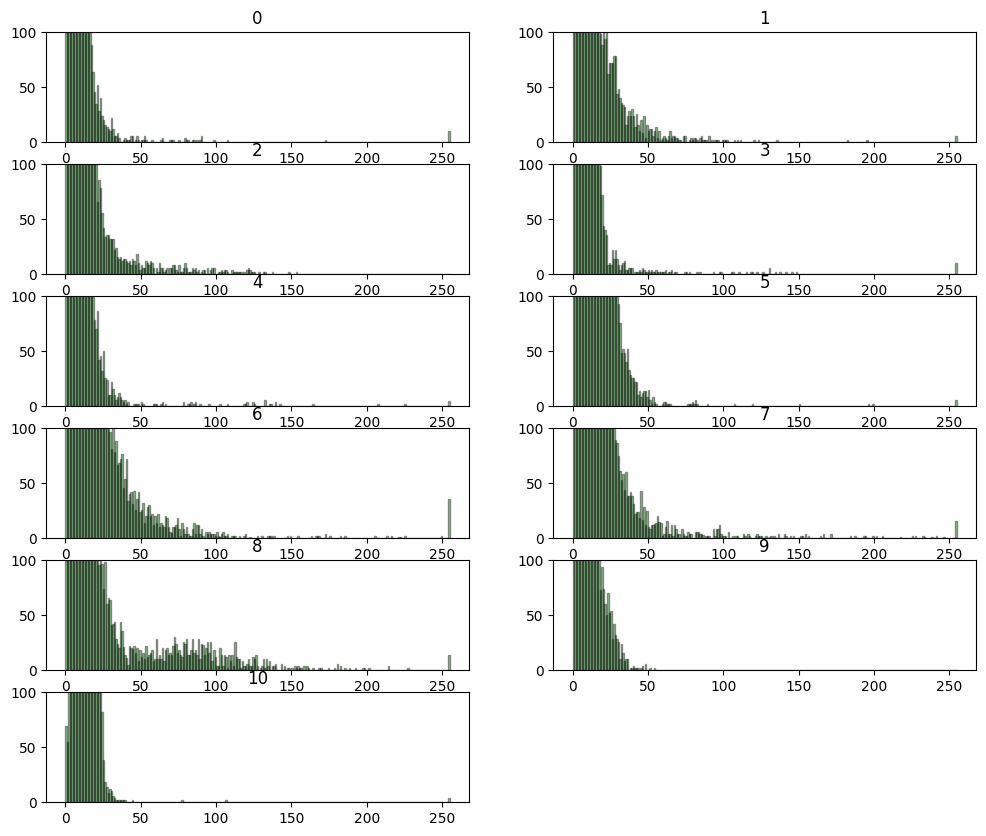

In [123]:
for i, f in enumerate(lidar_fpath):
    data = np.fromfile(f, dtype=np.float32).reshape(-1, 5)
    intensity = data[:, 3]
    plt.subplot(6, 2, i+1)
    plt.ylim(0, 100)
    plt.title(i)
    # plt.hist(intensity, color = 'green', alpha = 0.4, bins =255, range = [0, 255], edgecolor = 'black')
    # plot the histogram with upper and lower bound
    plt.hist(intensity, bins=255, range=(0, 255), color='green', alpha=0.4, edgecolor='black')
    # show the upper and lower bound

plt.rcParams["figure.figsize"] = (12, 10)
plt.show()